In [1]:
# Data from https://grouplens.org/datasets/movielens/latest/
# Put the downloaded csv files in the "Downloads" folder

import os
os.chdir("Downloads")
print(os.getcwd())


c:\Users\vonks\Documents\GitHub\Movie_Recs\Downloads


In [2]:
import pandas as pd

ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

data = ratings.merge(movies, on="movieId", how="left")

In [3]:
# Removing users with more than 1.000 ratings as these are likely to be bots or outliers
# See Data_Exploration.ipynb for more details about cleaning and outlier detection

ratings_per_user = data.groupby('userId').size()
outliers = ratings_per_user[ratings_per_user > 1000] # or 10.000
filtered_data = data[~data['userId'].isin(outliers.index)]

# Table of removed users
removed_users_table = outliers.reset_index()
removed_users_table.columns = ['userId', 'num_ratings']

#print(removed_users_table)


## User Similarity Recommendation

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Parameters
min_ratings_per_user = 20  # minimum ratings per user
sample_size = 100
K = 10                     # number of recommendations
liked_threshold = 4
top_n_input = 4            # top liked movies for similarity

# -----------------------------
# Select active users
# -----------------------------
liked_mask = filtered_data['rating'] >= liked_threshold
liked_counts = filtered_data[liked_mask].groupby('userId').size()
active_users = filtered_data.groupby('userId').size()
active_users = active_users[(active_users >= min_ratings_per_user)].index
users_with_5_liked = liked_counts[liked_counts >= top_n_input + 1].index
active_users = active_users.intersection(users_with_5_liked)

# Random sample
np.random.seed(123)
sampled_users = np.random.choice(active_users, size=sample_size, replace=False)

# -----------------------------
# Build user-item matrix using only top-4 liked movies per user
# -----------------------------
train_ratings = []
test_ratings = []
profile_movies = {}

for uid in sampled_users:
    user_data = filtered_data[filtered_data['userId'] == uid]
    liked_movies = user_data[user_data['rating'] >= liked_threshold]
    
    # Take top-4 liked movies as profile/train
    top_movies = liked_movies.sort_values('rating', ascending=False).head(top_n_input)['movieId'].tolist()
    profile_movies[uid] = top_movies
    
    # Test set = all other movies
    test = user_data[~user_data['movieId'].isin(top_movies)]
    
    train_ratings.append(user_data[user_data['movieId'].isin(top_movies)])
    test_ratings.append(test)

train_ratings = pd.concat(train_ratings)
test_ratings = pd.concat(test_ratings)

# -----------------------------
# Build user-item matrix
# -----------------------------
user_ids = train_ratings['userId'].unique()
movie_ids = train_ratings['movieId'].unique()
user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
movie_to_idx = {mid: i for i, mid in enumerate(movie_ids)}
idx_to_movie = {i: mid for mid, i in movie_to_idx.items()}

n_users = len(user_ids)
n_movies = len(movie_ids)
user_item_matrix = np.zeros((n_users, n_movies))

for row in train_ratings.itertuples():
    u_idx = user_to_idx[row.userId]
    m_idx = movie_to_idx[row.movieId]
    user_item_matrix[u_idx, m_idx] = row.rating

# -----------------------------
# Generate recommendations
# -----------------------------
user_metrics = []

# Store test set for each user to use in Top-10 block
user_test_dict = {}

for uid in sampled_users:
    u_idx = user_to_idx.get(uid)
    if u_idx is None:
        continue
    
    user_vector = user_item_matrix[u_idx, :]
    
    # Profile movies indices
    top_indices = [movie_to_idx[mid] for mid in profile_movies[uid] if mid in movie_to_idx]
    if len(top_indices) == 0:
        continue

    # Find relevant users who rated at least one profile movie
    rel_users = np.any(user_item_matrix[:, top_indices] > 0, axis=1)
    rel_users[u_idx] = False
    relevant_users_matrix = user_item_matrix[rel_users, :]

    if relevant_users_matrix.shape[0] == 0:
        continue

    # Cosine similarity on profile movies
    sims = cosine_similarity([user_vector[top_indices]], relevant_users_matrix[:, top_indices])[0]
    if np.sum(sims) == 0:
        continue

    # Predict scores for unseen movies
    unseen = np.where(user_vector == 0)[0]
    if len(unseen) == 0:
        continue

    weighted_scores = np.zeros(len(unseen))
    for i, m_idx in enumerate(unseen):
        weighted_scores[i] = np.sum(relevant_users_matrix[:, m_idx] * sims) / (np.sum(sims) + 1e-8)

    top_recs_idx = np.argsort(weighted_scores)[::-1][:K]
    recommended_movie_ids = [idx_to_movie[unseen[i]] for i in top_recs_idx]

    # Test set = all ratings except the profile movies
    user_test = test_ratings[test_ratings['userId'] == uid]
    test_liked = set(user_test[user_test['rating'] >= liked_threshold]['movieId'])
    test_not_liked = set(user_test[user_test['rating'] < liked_threshold]['movieId'])

    # Save test set for Top-10 block
    user_test_dict[uid] = {'test_liked': test_liked, 'test_not_liked': test_not_liked}

    user_metrics.append({
        'recommended': recommended_movie_ids,
        'test_liked': test_liked,
        'test_not_liked': test_not_liked
    })


In [15]:
#Evaluation

all_movie_ids = set(filtered_data['movieId'].unique())
K = 10  # top-K recommendations
liked_threshold = 4.0

counts_per_user = []
hit_rates, precisions, recalls = [], [], []

#filtered_user_metrics = [um for um in user_metrics if len(um['test_liked']) > 0]

for um in user_metrics:
    # Unpack the information per user (um)
    recommended = set(um['recommended'])
    test_liked = um['test_liked']
    test_not_liked = um['test_not_liked']
    test_movies = test_liked | test_not_liked

    # Metrics for table
    rec_watched_liked = len(recommended & test_liked)
    rec_watched_not_liked = len(recommended & test_not_liked)
    rec_not_watched = len(recommended - test_movies)

    nonrec = all_movie_ids - recommended
    nonrec_watched_liked = len(nonrec & test_liked)
    nonrec_watched_not_liked = len(nonrec & test_not_liked)
    nonrec_not_watched = len(nonrec - test_movies)

    counts_per_user.append({
        'Recommended_Watched+Liked': rec_watched_liked,
        'Recommended_Watched+NotLiked': rec_watched_not_liked,
        'Recommended_NotWatched': rec_not_watched,
        'NotRecommended_Watched+Liked': nonrec_watched_liked,
        'NotRecommended_Watched+NotLiked': nonrec_watched_not_liked,
        'NotRecommended_NotWatched': nonrec_not_watched
    })

    # Hit Rate = 1 if at least one liked movie is recommended
    hit = 1 if len(recommended & test_liked) > 0 else 0

    # Precision and Recall K
    precision = len(recommended & test_liked) / len(recommended) if len(recommended) > 0 else 0
    recall = len(recommended & test_liked) / len(test_liked) if len(test_liked) > 0 else 0
    
    hit_rates.append(hit)
    precisions.append(precision)
    recalls.append(recall)

# Table with averages
counts_df = pd.DataFrame(counts_per_user)
average_counts = counts_df.mean()

table_usersim = pd.DataFrame({
    'Recommended': [
        average_counts['Recommended_Watched+Liked'],
        average_counts['Recommended_Watched+NotLiked'],
        average_counts['Recommended_NotWatched']
    ],
    'Not Recommended': [
        average_counts['NotRecommended_Watched+Liked'],
        average_counts['NotRecommended_Watched+NotLiked'],
        average_counts['NotRecommended_NotWatched']
    ]
}, index=['Liked', 'Not Liked', 'Not Watched'])

# Add totals column
table_usersim['Total'] = table_usersim['Recommended'] + table_usersim['Not Recommended']

print("Recommendations based on user similarity of liked movies in 100 users:")
print(table_usersim)

avg_hit_rate = np.mean(hit_rates)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

print("\nAverage metrics:")
print(f"Hit rate in {K} recs: {avg_hit_rate:.3f}")
print(f"Precision in {K} recs: {avg_precision:.3f}")
print(f"Recall in {K} recs: {avg_recall:.3f}")


Recommendations based on user similarity of liked movies in 100 users:
             Recommended  Not Recommended         Total
Liked           1.819149        73.340426     75.159574
Not Liked       1.074468        84.787234     85.861702
Not Watched     7.106383     59306.872340  59313.978723

Average metrics:
Hit rate in 10 recs: 0.681
Precision in 10 recs: 0.182
Recall in 10 recs: 0.034


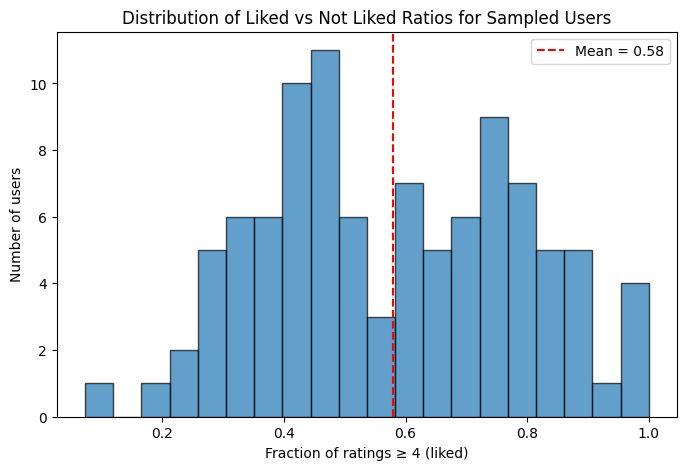

In [12]:
import matplotlib.pyplot as plt

liked_threshold = 4

# Count liked vs not liked for each sampled user
user_ratios = []

for uid in sampled_users:
    user_data = filtered_data[filtered_data['userId'] == uid]
    liked = (user_data['rating'] >= liked_threshold).sum()
    not_liked = (user_data['rating'] < liked_threshold).sum()
    total = liked + not_liked
    
    if total > 0:
        ratio = liked / total
        user_ratios.append(ratio)

# Plot histogram of ratios
plt.figure(figsize=(8, 5))
plt.hist(user_ratios, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(user_ratios), color='red', linestyle='--', label=f"Mean = {np.mean(user_ratios):.2f}")
plt.xlabel("Fraction of ratings ≥ 4 (liked)")
plt.ylabel("Number of users")
plt.title("Distribution of Liked vs Not Liked Ratios for Sampled Users")
plt.legend()
plt.show()


The ratio of liked vs not liked seems to be pretty close to 1:1 on average. I was a bit surprised to see the numbers this close to each other, but looking at the distribution it checks out.
## Recommending based on top 10 rated movies overall

In [10]:
import pandas as pd
import numpy as np

K = 10
min_ratings_per_movie = 10000  # threshold applied on the ENTIRE dataset

movie_stats_all = filtered_data.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
eligible_movies = movie_stats_all[movie_stats_all['count'] >= min_ratings_per_movie]

# Sort by average rating descending
top_movies_by_avg_all = eligible_movies.sort_values('mean', ascending=False).head(K)

# Merge with movie titles
top_movies_summary = top_movies_by_avg_all.merge(movies[['movieId', 'title']], on='movieId', how='left')

# Rename columns
top_movies_summary.rename(columns={'mean': 'average_rating', 'count': 'num_ratings'}, inplace=True)
top_movies_summary = top_movies_summary[['movieId', 'title', 'average_rating', 'num_ratings']]

# Display top movies
print(f"Top-{K} Movies in the Entire Dataset (min {min_ratings_per_movie} ratings):")
print(top_movies_summary)

# Save movie IDs for later recommendation block
top_movie_ids = top_movies_summary['movieId'].tolist()


Top-10 Movies in the Entire Dataset (min 10000 ratings):
   movieId                                              title  average_rating  \
0      318                   Shawshank Redemption, The (1994)        4.419662   
1   202439                                    Parasite (2019)        4.353265   
2      858                              Godfather, The (1972)        4.326352   
3       50                         Usual Suspects, The (1995)        4.274643   
4     1221                     Godfather: Part II, The (1974)        4.273383   
5     1203                                12 Angry Men (1957)        4.273294   
6     2019        Seven Samurai (Shichinin no samurai) (1954)        4.261119   
7      527                            Schindler's List (1993)        4.246293   
8     5618  Spirited Away (Sen to Chihiro no kamikakushi) ...        4.240083   
9     2959                                  Fight Club (1999)        4.239283   

   num_ratings  
0       118898  
1        11163  


In [13]:
import numpy as np
import pandas as pd

K = 10
all_movie_ids = set(filtered_data['movieId'].unique())

counts_per_user = []
hit_rates, precisions, recalls = [], [], []

# Global top-K recommended movies
recommended = set(top_movie_ids[:K])

for uid in sampled_users:
    if uid not in user_test_dict:
        continue
    
    test_liked = user_test_dict[uid]['test_liked']
    test_not_liked = user_test_dict[uid]['test_not_liked']
    test_movies = test_liked | test_not_liked

    # Metrics
    rec_watched_liked = len(recommended & test_liked)
    rec_watched_not_liked = len(recommended & test_not_liked)
    rec_not_watched = len(recommended - test_movies)

    nonrec = all_movie_ids - recommended
    nonrec_watched_liked = len(nonrec & test_liked)
    nonrec_watched_not_liked = len(nonrec & test_not_liked)
    nonrec_not_watched = len(nonrec - test_movies)

    counts_per_user.append({
        'Recommended_Watched+Liked': rec_watched_liked,
        'Recommended_Watched+NotLiked': rec_watched_not_liked,
        'Recommended_NotWatched': rec_not_watched,
        'NotRecommended_Watched+Liked': nonrec_watched_liked,
        'NotRecommended_Watched+NotLiked': nonrec_watched_not_liked,
        'NotRecommended_NotWatched': nonrec_not_watched
    })

    # Hit rate, precision, recall
    hit_rates.append(1 if rec_watched_liked > 0 else 0)
    precisions.append(rec_watched_liked / K)
    recalls.append(rec_watched_liked / len(test_liked) if len(test_liked) > 0 else 0)

# Build table with totals
counts_df = pd.DataFrame(counts_per_user)
avg_counts = counts_df.mean()

table_top10 = pd.DataFrame({
    'Recommended': [
        avg_counts['Recommended_Watched+Liked'],
        avg_counts['Recommended_Watched+NotLiked'],
        avg_counts['Recommended_NotWatched']
    ],
    'Not Recommended': [
        avg_counts['NotRecommended_Watched+Liked'],
        avg_counts['NotRecommended_Watched+NotLiked'],
        avg_counts['NotRecommended_NotWatched']
    ]
}, index=['Liked', 'Not Liked', 'Not Watched'])

table_top10['Total'] = table_top10['Recommended'] + table_top10['Not Recommended']

print(f"Top-{K} Global Recommendations Validation for {len(sampled_users)} Users:")
print(table_top10)
print("\nAverage metrics:")
print(f"Hit rate in {K} recs: {np.mean(hit_rates):.3f}")
print(f"Precision in {K} recs: {np.mean(precisions):.3f}")
print(f"Recall in {K} recs: {np.mean(recalls):.3f}")


Top-10 Global Recommendations Validation for 100 Users:
             Recommended  Not Recommended         Total
Liked           1.904255        73.255319     75.159574
Not Liked       0.361702        85.500000     85.861702
Not Watched     7.734043     59306.244681  59313.978723

Average metrics:
Hit rate in 10 recs: 0.734
Precision in 10 recs: 0.190
Recall in 10 recs: 0.032


In [103]:
import pandas as pd

# Prepare the table
rows = []

for mid in top_movie_ids[:10]:
    liked_count = 0
    not_liked_count = 0
    for uid in sampled_users:
        uid_int = int(uid)
        if uid_int in user_test_dict:
            test_liked = user_test_dict[uid_int]['test_liked']
            test_not_liked = user_test_dict[uid_int]['test_not_liked']
            if mid in test_liked:
                liked_count += 1
            elif mid in test_not_liked:
                not_liked_count += 1
    total_rated = liked_count + not_liked_count
    not_watched_count = len(sampled_users) - total_rated
    
    rows.append({
        'MovieId': mid,
        'Liked': liked_count,
        'Not Liked': not_liked_count,
        'Not Watched': not_watched_count,
        'Total Rated': total_rated
    })

# Convert to DataFrame
top10_test_table = pd.DataFrame(rows)

# Optional: merge with movie titles if available
if 'movies' in globals():
    top10_test_table = top10_test_table.merge(movies[['movieId', 'title']], 
                                              left_on='MovieId', right_on='movieId', 
                                              how='left').drop(columns=['movieId'])

# Reorder columns
top10_test_table = top10_test_table[['MovieId', 'title', 'Liked', 'Not Liked', 'Not Watched', 'Total Rated']]

print(top10_test_table)


   MovieId                                              title  Liked  \
0      318                   Shawshank Redemption, The (1994)     16   
1   202439                                    Parasite (2019)      2   
2      858                              Godfather, The (1972)     13   
3       50                         Usual Suspects, The (1995)      9   
4     1221                     Godfather: Part II, The (1974)     11   
5     1203                                12 Angry Men (1957)      3   
6     2019        Seven Samurai (Shichinin no samurai) (1954)      6   
7      527                            Schindler's List (1993)     16   
8     5618  Spirited Away (Sen to Chihiro no kamikakushi) ...     12   
9     2959                                  Fight Club (1999)     20   

   Not Liked  Not Watched  Total Rated  
0          4           80           20  
1          0           98            2  
2          2           85           15  
3          3           88           12  
4 

Performance seems good. However, it has to be kept in mind that this is a biased metric because these are the highest rated movies in the dataset. This is also less personalized than user similarity.

## Looking at genres:

In [104]:
# Introducing genres
import pandas as pd

movies['genre_list'] = movies['genres'].str.split('|')

all_genres = sorted({g for genres in movies['genre_list'] for g in genres})

# One-hot encode genres
for g in all_genres:
    movies[g] = movies['genre_list'].apply(lambda x: int(g in x))

filtered_data_genres = filtered_data.merge(movies[['movieId'] + all_genres], on='movieId', how='left')


In [105]:
# Minimum ratings thresholds to make data manageable

min_movie_ratings = 20
min_user_ratings = 5

# Filter movies
movie_counts = filtered_data_genres.groupby('movieId')['rating'].count()
movies_to_keep = movie_counts[movie_counts >= min_movie_ratings].index
filtered_data_genres = filtered_data_genres[filtered_data_genres['movieId'].isin(movies_to_keep)]

# Filter users
user_counts = filtered_data_genres.groupby('userId')['rating'].count()
users_to_keep = user_counts[user_counts >= min_user_ratings].index
filtered_data_genres = filtered_data_genres[filtered_data_genres['userId'].isin(users_to_keep)]


In [106]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed

K = 10
liked_threshold = 4.0
test_fraction = 0.2
n_jobs = -1
n_users_debug = 100

np.random.seed(123)
all_user_ids = filtered_data_genres['userId'].unique()
sample_user_ids = np.random.choice(all_user_ids, min(n_users_debug, len(all_user_ids)), replace=False)

# Filter dataset for these users
data_subset = filtered_data_genres[filtered_data_genres['userId'].isin(sample_user_ids)].copy()

# --------------------------
# Build movie-genre sparse matrix
# --------------------------
genre_columns = all_genres 
unique_movies = filtered_data_genres.drop_duplicates('movieId').set_index('movieId')
movie_ids = unique_movies.index.values
movie_genre_sparse = csr_matrix(unique_movies[genre_columns].values)
movie_genre_sparse = normalize(movie_genre_sparse, axis=1)
movieid_to_idx = {mid: i for i, mid in enumerate(movie_ids)}

# --------------------------
# Train/test split per user
# --------------------------
train_data = []
test_data = []
for user_id, group in data_subset.groupby('userId'):
    group = group.sample(frac=1, random_state=123)  # shuffle
    split_idx = int(len(group) * (1 - test_fraction))
    train_data.append(group.iloc[:split_idx])
    test_data.append(group.iloc[split_idx:])

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

# --------------------------
# Build user profiles from training data
# --------------------------
user_profiles = {}
user_rated_train = {}
user_test_liked = {}
user_test_not_liked = {}

for user_id, group in train_data.groupby('userId'):
    liked = group[group['rating'] >= liked_threshold]
    not_liked = group[group['rating'] < liked_threshold]

    if liked.empty:
        continue

    liked_indices = [movieid_to_idx[mid] for mid in liked['movieId'] if mid in movieid_to_idx]
    if not liked_indices:
        continue

    profile_vector = movie_genre_sparse[liked_indices].mean(axis=0)
    profile_vector = np.asarray(profile_vector)  # convert from np.matrix
    profile_vector = normalize(profile_vector)  # normalize
    user_profiles[user_id] = profile_vector.ravel()
    user_rated_train[user_id] = set(group['movieId'])

# --------------------------
# Recommendation function
# --------------------------
def recommend_for_user(user_id, profile_vector, user_rated_train, movie_ids, movie_genre_sparse, K=10):
    rated_movies = user_rated_train.get(user_id, set())
    candidate_ids = np.array([mid for mid in movie_ids if mid not in rated_movies])
    if len(candidate_ids) == 0:
        return {'userId': user_id, 'recommended': set()}
    candidate_indices = [movieid_to_idx[mid] for mid in candidate_ids]
    sims = np.asarray(movie_genre_sparse[candidate_indices].dot(profile_vector.T)).ravel()
    top_idx = np.argsort(-sims)[:min(K, len(candidate_ids))]
    recommended = set(candidate_ids[top_idx])
    return {'userId': user_id, 'recommended': recommended}

results = Parallel(n_jobs=n_jobs)(
    delayed(recommend_for_user)(
        user_id, profile, user_rated_train, movie_ids, movie_genre_sparse, K
    )
    for user_id, profile in user_profiles.items()
)

counts_per_user = []
hit_rates, precisions, recalls = [], [], []

for res in results:
    user_id = res['userId']
    recommended = res['recommended']

    user_test = test_data[test_data['userId'] == user_id]
    test_liked = set(user_test[user_test['rating'] >= liked_threshold]['movieId'])
    test_not_liked = set(user_test[user_test['rating'] < liked_threshold]['movieId'])
    test_movies = test_liked | test_not_liked

    rec_watched_liked = len(recommended & test_liked)
    rec_watched_not_liked = len(recommended & test_not_liked)
    rec_not_watched = len(recommended - test_movies)

    nonrec = set(movie_ids) - recommended
    nonrec_watched_liked = len(nonrec & test_liked)
    nonrec_watched_not_liked = len(nonrec & test_not_liked)
    nonrec_not_watched = len(nonrec - test_movies)

    counts_per_user.append({
        'Recommended_Watched+Liked': rec_watched_liked,
        'Recommended_Watched+NotLiked': rec_watched_not_liked,
        'Recommended_NotWatched': rec_not_watched,
        'NotRecommended_Watched+Liked': nonrec_watched_liked,
        'NotRecommended_Watched+NotLiked': nonrec_watched_not_liked,
        'NotRecommended_NotWatched': nonrec_not_watched
    })

    hit_rates.append(1 if rec_watched_liked > 0 else 0)
    precisions.append(len(recommended & test_liked) / len(recommended) if len(recommended) > 0 else 0)
    recalls.append(len(recommended & test_liked) / len(test_liked) if len(test_liked) > 0 else 0)

# Table
counts_df = pd.DataFrame(counts_per_user)
average_counts = counts_df.mean()
table = pd.DataFrame({
    'Recommended': [
        average_counts['Recommended_Watched+Liked'],
        average_counts['Recommended_Watched+NotLiked'],
        average_counts['Recommended_NotWatched']
    ],
    'Not Recommended': [
        average_counts['NotRecommended_Watched+Liked'],
        average_counts['NotRecommended_Watched+NotLiked'],
        average_counts['NotRecommended_NotWatched']
    ]
}, index=['Liked', 'Not Liked', 'Not Watched'])
table['Total'] = table['Recommended'] + table['Not Recommended']

print("Genre-based Recommendations (20/80 train/test split):")
print(table)

print("\nAverage metrics:")
print(f"Hit rate in {K} recs: {np.mean(hit_rates):.3f}")
print(f"Precision in {K} recs: {np.mean(precisions):.3f}")
print(f"Recall in {K} recs: {np.mean(recalls):.3f}")


Genre-based Recommendations (20/80 train/test split):
             Recommended  Not Recommended         Total
Liked           0.040816         8.040816      8.081633
Not Liked       0.020408         7.173469      7.193878
Not Watched     9.938776     16660.785714  16670.724490

Average metrics:
Hit rate in 10 recs: 0.041
Precision in 10 recs: 0.004
Recall in 10 recs: 0.018


Some thoughts after this
- Genre based seems to be the worst in both absolute number of liked movies and ratio with not liked.
- Top 10 movies used for recommendation have a good ratio of like to not liked, but this is expected from the highest rated movies in the dataset.
- User similarity has the highest absolute value of liked movies from the recommendations, indiciating that it is often the case that people actually watch the movies that were recommended to them.
- Movies that are unwatched make it more difficult to interpret recommendations, as it is unknown if the user would like this recommendation or not.
- Users seem to have similarity in which movies they watch, also if these movies are more often not rated at >= 4.

Genre predictions are inherently different because we actually have to train based on genres. Therefore, these outcome measures cannot be compared in an absolute way to the other recommendations.

## User similarity clustering
